# Open Access Practices at Universities
## The Data
In this project I want to explore the open access publishing practices of universities all over the world. Publishing research open access is the only way to make scientific knowledge equally available to everyone with an internet connection regardless of their origin and their available funds.

This project is based on the CWTS Leiden Ranking Open Edition 2023 Dataset<sup>1</sup> provided by the Centre for Science and Technology Studies (CWTS). The full dataset can be downloaded from Zenodo under the followig citation:

> Van Eck, N. J. (2024). CWTS Leiden Ranking Open Edition 2023 - Data [Data set]. Zenodo. https://doi.org/10.5281/zenodo.10579113

It is based on data provided by OpenAlex - a catalogue of scientific works, authors and institutions - and includes information about publications between the years 2006 and 2021.

## Open Access Related Terminology
The issue of Open Access publishing is quite complex therefore I will explain some central terminology here:

**Gold Open Access:** the final version of your scientific output is published open access by the publisher. i.e. it is permanently and freely available for anyone with an internet connection.

**Green Open Access:** also called 'self-archiving'. Here the authors themselves publish an earlier version of the manuscript of the scientific output in an online repository, while the publisher does not make the final version available freely.

**Bronze Open Access:** here, the scientific output is free to read only on the publishers website, however unlike the articles published as **gold** open access, **bronze** open access articles do not have an explicitly open license.

**Hybrid Open ACCESS:** here, subscription based journals publish individual papers in open access, asking for a publication fee, while also having institutions pay subscription fees. This practice is called double dipping.

## Analysis
### Preparations
First I load some relevant libraries and define a function that returns a pandas dataframe when executing a MySQL query.

In [1]:
# for data manipulations
import pandas as pd
import numpy as np
import mysql.connector as con

# for plotting
import seaborn as sns
import matplotlib.pyplot as plt

# for geodata
import geopandas as gpd
import folium
from folium import Marker, Popup
from folium.plugins import  MarkerCluster

# supress some jupyter warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

## Procuring the Data
### The CWTS Leiden Open Ranking
I downloaded the data from my the repository linked above and used it to built a locally hosted MySQL database. I then use a MySQL API to access this database and compile a single dataframe which I use for the analysis. I decided to use the two tables that contain some preprocessed data (*university_main_field_period_oa_indicators* and *university_main_field_period_impact_indicators*). The reason for this is that the less processed data (e.g. *pub* or *pub_oa_indicators*) is not very well described and it is not clear what data some of the columns contain.

In [ ]:
# connect to the database and start the cursor
cnx = con.connect(user='root',
                  password=input('password'),
                  host='localhost',
                  database='CWTS_leiden_ranking',
                  autocommit=True);

# cursor = cnx.cursor()

In [3]:
# retrieve open access data from a sql database
# the tables are very large so reading them in with pandas would take very long
q = """SELECT uni.university_full_name,
              uni.ror_id,
              uni.country_code, 
              uni.latitude,
              uni.longitude,
              field.main_field,
              period.period,
              oa.p,
              oa.pp_oa,
              oa.pp_gold_oa,
              oa.pp_hybrid_oa,
              oa.pp_bronze_oa,
              oa.pp_green_oa,
              impact.pp_top_1,
              impact.pp_top_10
       FROM   university AS uni
       INNER JOIN university_main_field_period_oa_indicators  AS oa
                  USING(university_id)
       INNER JOIN main_field AS field
                  USING(main_field_id)
       INNER JOIN period
                  USING(period_begin_year)
       INNER JOIN university_main_field_period_impact_indicators AS impact
                  USING(university_id,
                        main_field_id,
                        period_begin_year)
       WHERE impact.fractional_counting = 'False';
    """

df = pd.read_sql_query(q, cnx)

# close the mysql connector
#cursor.close()
cnx.close()

df.head()

university_full_name     ror_id country_code  latitude  longitude  \
0   University of Graz  01faaaf77           AT  47.07778  15.449902   
1   University of Graz  01faaaf77           AT  47.07778  15.449902   
2   University of Graz  01faaaf77           AT  47.07778  15.449902   
3   University of Graz  01faaaf77           AT  47.07778  15.449902   
4   University of Graz  01faaaf77           AT  47.07778  15.449902   

                         main_field     period           p     pp_oa  \
0  Mathematics and computer science  2006-2009  184.333333  0.297468   
1  Mathematics and computer science  2007-2010  219.500000  0.377373   
2  Mathematics and computer science  2008-2011  256.833333  0.401687   
3  Mathematics and computer science  2009-2012  289.166667  0.412680   
4  Mathematics and computer science  2010-2013  288.333333  0.470520   

   pp_gold_oa  pp_hybrid_oa  pp_bronze_oa  pp_green_oa  pp_top_1  pp_top_10  
0    0.013562      0.024412      0.123870     0.135624  0.009507   0.099947  
1    0.029613      0.027335      0.139711     0.180714  0.002289   0.107544  
2    0.036989      0.038936      0.116158     0.209604  0.001995   0.092174  
3    0.031124      0.046686      0.094524     0.240346  0.002937   0.107459  
4    0.039884      0.068786      0.086127     0.275723  0.003827   0.125446

## Country Code Data
Here I load the [wikipedia iso country codes dataset](https://www.kaggle.com/datasets/juanumusic/countries-iso-codes) to get the full names of the countries in which the universities are located.

In [4]:
country_codes = pd.read_csv('data/wikipedia-iso-country-codes.csv')
country_codes = country_codes.rename(columns={"English short name lower case":"country",
                                               "Alpha-2 code":"country_code",
                                               "Alpha-3 code":"ISO-3"})

In [5]:
country_codes

country country_code ISO-3  Numeric code     ISO 3166-2
0          Afghanistan           AF   AFG             4  ISO 3166-2:AF
1        Åland Islands           AX   ALA           248  ISO 3166-2:AX
2              Albania           AL   ALB             8  ISO 3166-2:AL
3              Algeria           DZ   DZA            12  ISO 3166-2:DZ
4       American Samoa           AS   ASM            16  ISO 3166-2:AS
..                 ...          ...   ...           ...            ...
241  Wallis and Futuna           WF   WLF           876  ISO 3166-2:WF
242     Western Sahara           EH   ESH           732  ISO 3166-2:EH
243              Yemen           YE   YEM           887  ISO 3166-2:YE
244             Zambia           ZM   ZMB           894  ISO 3166-2:ZM
245           Zimbabwe           ZW   ZWE           716  ISO 3166-2:ZW

[246 rows x 5 columns]

I join the country names to the main dataframe and proceed to drop and reorder some columns. I also transform the dataframe into a GeoPandas GeoDataFrame because I want to use geodata to visualise some of the results.

In [6]:
# join the country codes with the main dataframe
df = df.join(country_codes[['country', 'country_code', 'ISO-3']].set_index('country_code'), on='country_code')

# create a geodataframe
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['latitude'], df['longitude']))

# move country name column
col_2 = gdf.pop('country')
gdf.insert(1, 'country', col_2)

# rename some columns
gdf= gdf.rename(columns={'university_full_name':'university',
                         'p': 'num_pubs',
                         'pp_oa':'prop_pubs_oa',
                         'pp_gold_oa':'prop_pubs_gold_oa',
                         'pp_hybrid_oa':'prop_pubs_hybrid_oa',
                         'pp_bronze_oa':'prop_pubs_bronze_oa',
                         'pp_green_oa':'prop_pubs_green_oa',
                         'pp_top_1':'prop_pubs_top_1',
                         'pp_top_10':'prop_pubs_top_10'})

gdf.head()

university  country     ror_id country_code  latitude  longitude  \
0  University of Graz  Austria  01faaaf77           AT  47.07778  15.449902   
1  University of Graz  Austria  01faaaf77           AT  47.07778  15.449902   
2  University of Graz  Austria  01faaaf77           AT  47.07778  15.449902   
3  University of Graz  Austria  01faaaf77           AT  47.07778  15.449902   
4  University of Graz  Austria  01faaaf77           AT  47.07778  15.449902   

                         main_field     period    num_pubs  prop_pubs_oa  \
0  Mathematics and computer science  2006-2009  184.333333      0.297468   
1  Mathematics and computer science  2007-2010  219.500000      0.377373   
2  Mathematics and computer science  2008-2011  256.833333      0.401687   
3  Mathematics and computer science  2009-2012  289.166667      0.412680   
4  Mathematics and computer science  2010-2013  288.333333      0.470520   

   prop_pubs_gold_oa  prop_pubs_hybrid_oa  prop_pubs_bronze_oa  \
0           0.013562             0.024412             0.123870   
1           0.029613             0.027335             0.139711   
2           0.036989             0.038936             0.116158   
3           0.031124             0.046686             0.094524   
4           0.039884             0.068786             0.086127   

   prop_pubs_green_oa  prop_pubs_top_1  prop_pubs_top_10 ISO-3  \
0            0.135624         0.009507          0.099947   AUT   
1            0.180714         0.002289          0.107544   AUT   
2            0.209604         0.001995          0.092174   AUT   
3            0.240346         0.002937          0.107459   AUT   
4            0.275723         0.003827          0.125446   AUT   

                   geometry  
0  POINT (47.07778 15.4499)  
1  POINT (47.07778 15.4499)  
2  POINT (47.07778 15.4499)  
3  POINT (47.07778 15.4499)  
4  POINT (47.07778 15.4499)

## Loading university data
To look for some correlations, I will load two additional datasets:

### Times Higher Education (THE) university ranking (2021)
This dataset [is available on Kaggle](https://www.kaggle.com/datasets/matheusgratz/world-university-rankings-2021) and contains a ranking of the top ~1500 universities from the year 2021. The universities are scored on five main areas: **teaching, research, citations, international outlook, and industry income**. Each area has a score ranging from 0-100. Using a weighted combinations of these five areas, an overall score is calculated which is used to rank the universities. The methodology for this ranking is described [on the website of the times higher education university ranking](https://www.timeshighereducation.com/world-university-rankings/world-university-rankings-2021-methodology).

In [7]:
the = pd.read_csv('data/THE_ranking/universities_scores_ror_ids.csv')

In [8]:
# data transformation
# from rank 203, overall scores of ~50 ranks are combined as displayed as a range
# we will use the formula from the THE methodology explanations to calculate the scores again
# overall score = (T * 0.3) + (R * 0.3) + (C * 0.3) + (I * 0.025) + (IO * 0.075)
# T = teaching, R = research, C = citations, I = industry income, IO = intl outlook
the['overall score'] = round((the['teaching score'] * 0.3) + \
                               (the['research score'] * 0.3) + \
                               (the['citations score'] * 0.3) + \
                               (the['industry income score'] * 0.025) + \
                               (the['intl outlook score'] * 0.075),
                               1)
# add ROR ID
the['ROR ID'] = the['ROR ID'].str.slice(-9)
the = the.rename(columns={'ROR ID': 'ror_id'})

### Data from the European Tertiary Education Register (ETER)
The ETER is a database that contains microdata of European universities. The project is commissioned by the European Comission and data is collected annually and made [publicly available on the project website](https://eter-project.com/data/data-for-download-and-visualisations/database/). I selected a subset of the data that includes the following information:
* ETER ID YEAR: to select data from the year 2021
* ROR ID and English Insitution name: for combining tables
* Foundation year
* total third party funding in Euro
* total academic personnel (head count)
* total students enrolled

In [9]:
eter = pd.read_csv('data/ETER_university_data.csv', sep=';')

In [10]:
# some data transformations
# get only year from ETER ID Year
eter['ETER_year'] = eter['ETER ID Year'].str.slice(-4)
eter = eter.drop(columns=['ETER ID Year'])

# subset data for year 2021 only
eter = eter.loc[eter['ETER_year'] == '2021']

# get only 9 digit ror from ROR ID
eter['ROR ID'] = eter['ROR ID'].str.slice(-9)
eter = eter.rename(columns={'ROR ID': 'ror_id'})

# set nan values for missing values, confidential values 
# and small values (values 3 > 0 are coded as 's' in the dataset'
eter = eter.replace(['m', 'c', 's'], np.nan)

# convert some columns to numeric
eter['Total third party funding (EURO)'] = pd.to_numeric(eter['Total third party funding (EURO)'])
eter['Total academic personnel (HC)'] = pd.to_numeric(eter['Total academic personnel (HC)'])
eter['Total students enrolled ISCED 5-7'] = pd.to_numeric(eter['Total students enrolled ISCED 5-7'])

# a lot of the british unis have 'the' in the beginning of their name.
# this is not the case for the THE ranking so we remove the thes.
# infact, we remove the prepositions 'of' and 'and' as well to minimize data loss when joining
eter['English Institution Name'] = eter['English Institution Name'].str.replace(r'^The\s+', '', regex=True)

## Data for the Analysis
Going into the analysis, we have a dataframe that contains the following columns:
* **university:** name of the university
* **ror_id:** a unique persistent identifier for research institutions
* **country:** name of the country in which the university resides
* **country_code:** a two letter country code
* **latitude:** latitude coordinate of the exact location of the university
* **longitude:** longitude coordinate of the exact location of the university
* **main_field:** main scientific field can have one of the following values: All sciences, Biomedical and health sciences, Life and earth sciences, Mathematics and computer science, Physical sciences and engineering, Social sciences and humanities.
* **period:** three year period over which the measures were taken
* **prop_pubs_oa:** proportion of open access publications (all "colours" combined)
* **prop_pubs_gold_oa:** proportion of gold open access publications
* **prop_pubs_hybrid_oa:** proportion of hybrid open access publications
* **prop_pubs_bronze_oa:** proportion of bronze open access publications
* **prop_pubs_green_oa:** proportion of green open access publications
* **prop_pubs_top_1:** proportion of publications ranked in the top 1%
* **prop_pubs_top_10:** proportion of publications ranked in the top 10%
* **ISO-3:** a three letter country code
* **geometry:** geocoordinates of the universities location

Additionally, it should be said, that the publication numbers refer to all publications to which the respective university contributed. That is, collaborative publications are counted fully as a publication of this university. It is not quite clear to me, why many of the publication numbers still are decimal numbers, however, when they are rounded to integers, they conform with the numbers that appear on the [official website of the CWTS Leiden Ranking Open Edition for Open Access Indicators](https://open.leidenranking.com/ranking/2023/list). Accordingly, I will use them as they are.

There are several NaN values in the dataset. These appear to be the result of institutions not having any publications in a time period. I will therefore leave them as is.

In [11]:
gdf.isna().sum()

university               0
country                  0
ror_id                   0
country_code             0
latitude                 0
longitude                0
main_field               0
period                   0
num_pubs                 0
prop_pubs_oa           190
prop_pubs_gold_oa      190
prop_pubs_hybrid_oa    190
prop_pubs_bronze_oa    190
prop_pubs_green_oa     190
prop_pubs_top_1        190
prop_pubs_top_10       190
ISO-3                    0
geometry                 0
dtype: int64

In [12]:
gdf.loc[gdf['prop_pubs_oa'].isna()].head()

university country     ror_id  \
66977  National Research Tomsk Polytechnic University  Russia  00a45v709   
71812              Shenyang Pharmaceutical University   China  03dnytd23   
84760                            University of Kashan    Iran  015zmr509   
89206    Shaanxi University of Science and Technology   China  034t3zs45   
89908      National Research Nuclear University MEPhI  Russia  04w8z7f34   

      country_code   latitude   longitude                      main_field  \
66977           RU  56.465278   84.950278  Social sciences and humanities   
71812           CN  41.769228  123.446130  Social sciences and humanities   
84760           IR  34.014795   51.405540  Social sciences and humanities   
89206           CN  34.381229  108.978412  Social sciences and humanities   
89908           RU  55.650017   37.664256  Social sciences and humanities   

          period  num_pubs  prop_pubs_oa  prop_pubs_gold_oa  \
66977  2007-2010       0.0           NaN                NaN   
71812  2006-2009       0.0           NaN                NaN   
84760  2006-2009       0.0           NaN                NaN   
89206  2006-2009       0.0           NaN                NaN   
89908  2006-2009       0.0           NaN                NaN   

       prop_pubs_hybrid_oa  prop_pubs_bronze_oa  prop_pubs_green_oa  \
66977                  NaN                  NaN                 NaN   
71812                  NaN                  NaN                 NaN   
84760                  NaN                  NaN                 NaN   
89206                  NaN                  NaN                 NaN   
89908                  NaN                  NaN                 NaN   

       prop_pubs_top_1  prop_pubs_top_10 ISO-3                geometry  
66977              NaN               NaN   RUS    POINT (56.465 84.95)  
71812              NaN               NaN   CHN  POINT (41.769 123.446)  
84760              NaN               NaN   IRN   POINT (34.015 51.406)  
89206              NaN               NaN   CHN  POINT (34.381 108.978)  
89908              NaN               NaN   RUS    POINT (55.65 37.664)

## Exploratory Data Analysis
Let's look at how the proportion of papers published open access has changed over time. In this case let's first look at different scientific fields.

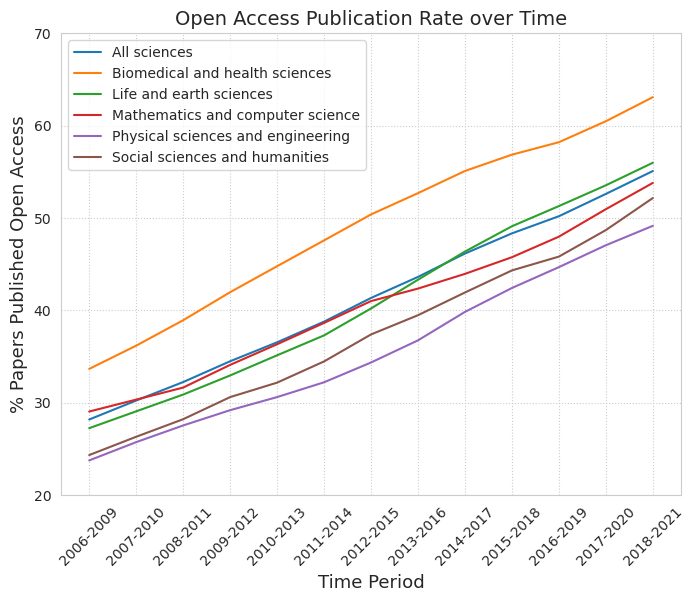

In [14]:
# prepare data for plotting
overall_oa_dev = (gdf.groupby(['period', 'main_field'])['prop_pubs_oa'].mean()*100).reset_index()

# plot
sns.set_style('whitegrid', {'grid.linestyle': ':'})
plt.figure(figsize=(8, 6))
sns.lineplot(data=overall_oa_dev, x='period', y='prop_pubs_oa', hue='main_field') # specify data

# set title and labels
plt.title('Open Access Publication Rate over Time', fontsize=14)
plt.ylabel('% Papers Published Open Access', fontsize=13)
plt.xlabel('Time Period', fontsize=13)

# add legend
plt.legend()

# cosmetics
plt.xticks(rotation=45)
plt.ylim((20, 70))

#plt.savefig('plots/overall_oa_rate_over_time.png', bbox_inches='tight')
plt.show()

Now let's look at different types of open access publications.

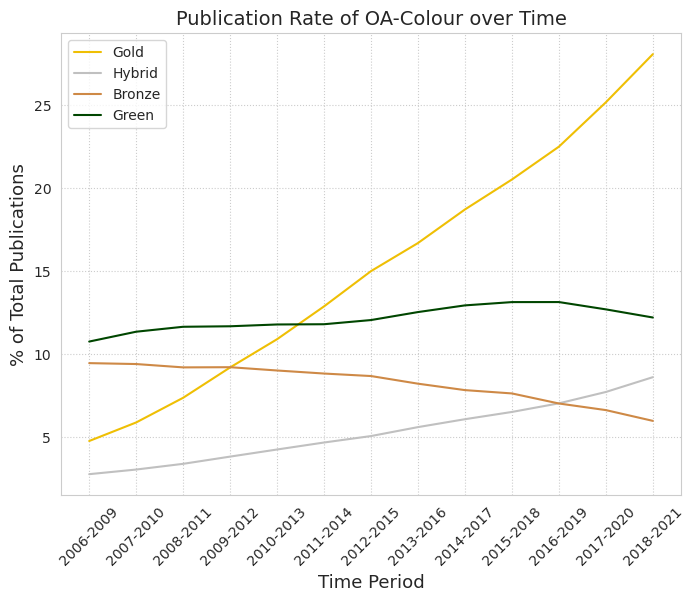

In [15]:
# prepare data for plotting
oa_colors_dev_line = (gdf.groupby('period')[['prop_pubs_gold_oa', 'prop_pubs_hybrid_oa',
       'prop_pubs_bronze_oa', 'prop_pubs_green_oa']].mean()*100).reset_index()

# set time period as index
oa_colors_dev_line.set_index('period', inplace=True)
# transform the data into a structure that allows us to plot them together
oa_colors_dev_line = oa_colors_dev_line.stack().reset_index().rename(columns={'level_1':'oa_colour', 0:'prop'}).copy()

# create a color palette for the different OA colors
colors_line = sns.color_palette(['#EFBF04', '#C0C0C0', '#CE8946', '#004600'])

# create a line plot
plt.figure(figsize=(8, 6))
ax = sns.lineplot(data=oa_colors_dev_line, x='period', y='prop', hue='oa_colour', palette=colors_line)

# set title and labels
plt.title('Publication Rate of OA-Colour over Time', fontsize=14)
plt.xlabel('Time Period', fontsize=13)
plt.ylabel('% of Total Publications', fontsize=13)
plt.xticks(rotation=45)

# generate the legend
handles, labels = ax.get_legend_handles_labels()
labels = ['Gold', 'Hybrid', 'Bronze', 'Green']
plt.legend(handles=handles, labels=labels)

#plt.savefig('plots/oa_colours_rate_over_time.png', bbox_inches='tight')
plt.show()

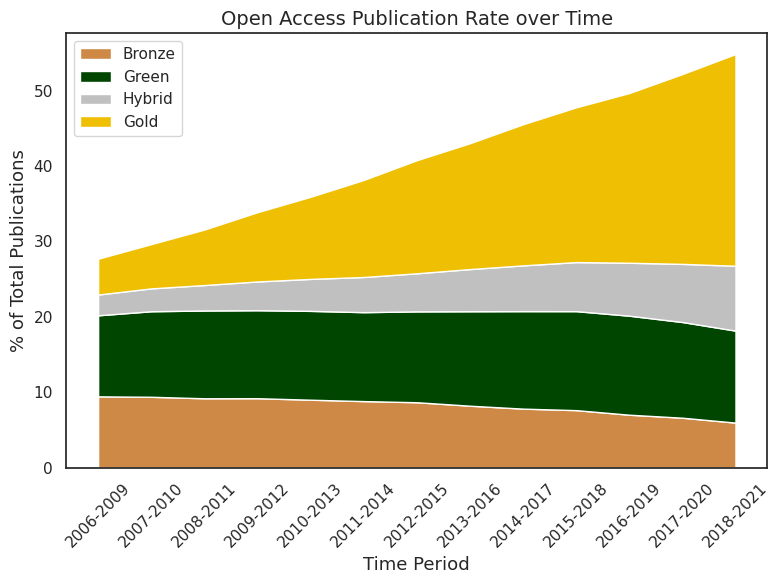

In [16]:
oa_colors_dev_stack = (gdf.groupby('period')[['prop_pubs_gold_oa', 'prop_pubs_hybrid_oa',
       'prop_pubs_bronze_oa', 'prop_pubs_green_oa']].mean()*100).reset_index()

colors_stack = ['#CE8946','#004600', '#C0C0C0', '#EFBF04']

sns.set_theme()
sns.set_style('white')
plt.figure(figsize=(8, 6))
plt.stackplot(oa_colors_dev_stack['period'], 
              oa_colors_dev_stack['prop_pubs_bronze_oa'],
              oa_colors_dev_stack['prop_pubs_green_oa'],
              oa_colors_dev_stack['prop_pubs_hybrid_oa'],
              oa_colors_dev_stack['prop_pubs_gold_oa'],
              labels=['Bronze', 'Green',
                      'Hybrid', 'Gold'],
              colors=colors_stack)
plt.title('Open Access Publication Rate over Time', fontsize=14)
plt.ylabel('% of Total Publications', fontsize=13)
plt.xlabel('Time Period', fontsize=13)
plt.legend(loc='upper left')
plt.xticks(rotation=45)

plt.tight_layout()
#plt.savefig('plots/oa_colours_rate_over_time_stack.png', bbox_inches='tight')
plt.show()

Next, I would like to see, which Universities have the highest proporion of open access publications. I will calculate this for all universities worldwide and for German universities.

I will first query the top 10 of the most recent period. Then I will use this to query the data from these ten universities and use it to make a graph of their open access developement.

In [17]:
# get data from most recent time period (2018-2021)
overall_oa_18_21 = gdf[['period', 'prop_pubs_oa', 'country', 
                        'university', 'main_field', 'latitude', 'longitude']].loc[(gdf.period == '2018-2021') 
                                                                              & (gdf.main_field == 'All sciences')] \
                                                                              .sort_values(by='prop_pubs_oa', ascending=False) \
                                                                              .reset_index(drop=True)

# show data from the most recent period from all universities worldwide
overall_oa_18_21['prop_pubs_oa'] = overall_oa_18_21['prop_pubs_oa']*100
overall_oa_18_21.head(10)

period  prop_pubs_oa         country  \
0  2018-2021     96.418234     Netherlands   
1  2018-2021     94.432459  United Kingdom   
2  2018-2021     91.734694  United Kingdom   
3  2018-2021     91.605691  United Kingdom   
4  2018-2021     91.101695  United Kingdom   
5  2018-2021     90.933502  United Kingdom   
6  2018-2021     90.821736  United Kingdom   
7  2018-2021     90.791139  United Kingdom   
8  2018-2021     90.548870  United Kingdom   
9  2018-2021     90.499284     Netherlands   

                                     university    main_field   latitude  \
0                       University of Groningen  All sciences  53.219308   
1  London School of Hygiene & Tropical Medicine  All sciences  51.520621   
2                     University of Strathclyde  All sciences  55.862157   
3                          University of Dundee  All sciences  56.458257   
4                     University of East Anglia  All sciences  52.621948   
5                      University of St Andrews  All sciences  56.341687   
6                             Durham University  All sciences  54.765004   
7                        University of Stirling  All sciences  56.145500   
8                         University of Reading  All sciences  51.441461   
9                          University of Twente  All sciences  52.241079   

   longitude  
0   6.562976  
1  -0.130063  
2  -4.243690  
3  -2.982186  
4   1.239080  
5  -2.792763  
6  -1.578310  
7  -3.919500  
8  -0.941944  
9   6.852438

In [18]:
# create a folium map object centered on the atlantic ocean
# so we can see north america and europe (no asian unis in top 100)
map_world = folium.Map(location=[45,-30], tiles='OpenStreetMap', zoom_start=3)

# create a cluster object
cluster = MarkerCluster()

# create popups for every row in the top 100 
# and add geopoints to clustres
for idx, row in overall_oa_18_21.head(100).iterrows():
    
    # write popup information
    popup_str = f'{row.university}: {str(round(row.prop_pubs_oa, 1))} %'
    # create the markers with popups and add them to the clusters
    cluster.add_child(Marker([row['latitude'], row['longitude']], popup=Popup(popup_str, max_width=250)))
    
# add the clusters to the map
map_world.add_child(cluster)

#map_world.save('plots/top_100_oa_unis_world_2018-2021.html')
map_world

We can look at the developement of open access practices of the most recent top 10 universities world wide.

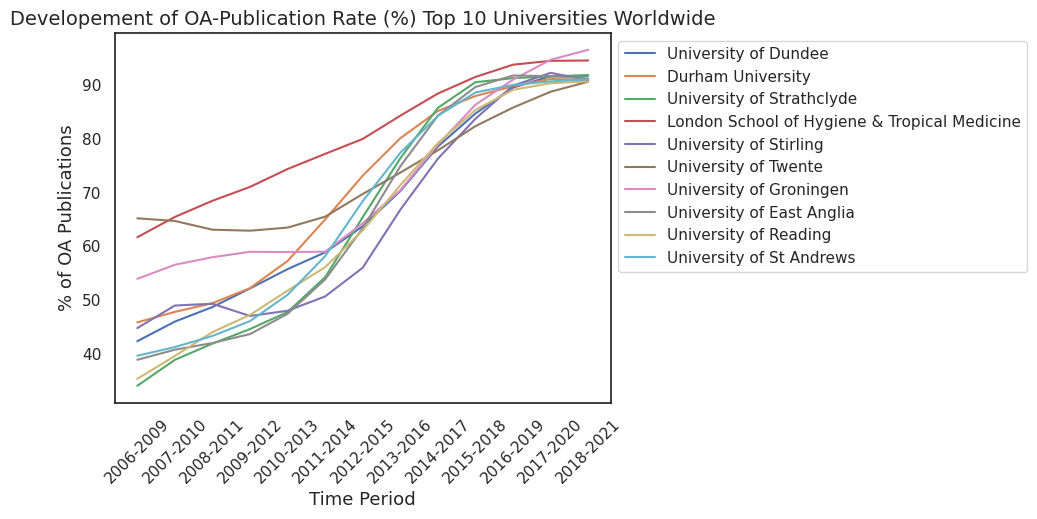

In [19]:
# pull historic data for the most recent top 10 universities from full dataframe
# I only use aggregated data from all fields
oa_historic_from_recent_top_10_world = gdf[['period', 'prop_pubs_oa', 'country',
                                            'university', 'main_field']] \
                                             .loc[gdf.university.isin(overall_oa_18_21.university.head(10)) 
                                             & (gdf.main_field == 'All sciences')]

# make oa rate more intuitive by converting it to %
oa_historic_from_recent_top_10_world['prop_pubs_oa'] = oa_historic_from_recent_top_10_world['prop_pubs_oa'] * 100

# create a line plot
sns.lineplot(data=oa_historic_from_recent_top_10_world, x='period', y='prop_pubs_oa', hue='university', err_style=None)

# set titles and axis labels, etc
plt.ylabel('% of OA Publications', fontsize=13)
plt.xlabel('Time Period', fontsize=13)
plt.xticks(rotation=45)
plt.title('Developement of OA-Publication Rate (%) Top 10 Universities Worldwide', fontsize=14)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

#plt.savefig('plots/oa_publication_rate_dev_top_10_world_2018-2021.png', bbox_inches='tight')
plt.show()

And we can look at the locations of the top 10 German universities.

In [20]:
# get most recent (again, for all sciences only)
german_oa_18_21 = gdf[['period', 'prop_pubs_oa', 'country',
                       'university', 'main_field', 'latitude', 'longitude']].loc[(gdf.period == '2018-2021') 
                                                                            & (gdf.main_field == 'All sciences') & (gdf.country == 'Germany')] \
                                                                            .sort_values(by='prop_pubs_oa', ascending=False) \
                                                                            .reset_index(drop=True)

# show data from the most recent period only from German universities
german_oa_18_21['prop_pubs_oa'] = german_oa_18_21['prop_pubs_oa']*100
german_oa_18_21.head(10)

period  prop_pubs_oa  country  \
0  2018-2021     79.414784  Germany   
1  2018-2021     75.455520  Germany   
2  2018-2021     75.320911  Germany   
3  2018-2021     74.893632  Germany   
4  2018-2021     74.664389  Germany   
5  2018-2021     74.239367  Germany   
6  2018-2021     73.322103  Germany   
7  2018-2021     72.328585  Germany   
8  2018-2021     72.023182  Germany   
9  2018-2021     71.523775  Germany   

                                          university    main_field   latitude  \
0                             University of Konstanz  All sciences  47.688748   
1  University of Veterinary Medicine Hannover, Fo...  All sciences  52.354637   
2                             University of Augsburg  All sciences  48.332197   
3                              Heidelberg University  All sciences  49.419126   
4                            Hannover Medical School  All sciences  52.384177   
5                     Humboldt-Universität zu Berlin  All sciences  52.517883   
6                           Freie Universität Berlin  All sciences  52.452533   
7             Ludwig-Maximilians-Universität München  All sciences  48.150875   
8                                 University of Bonn  All sciences  50.726758   
9               Heinrich Heine University Düsseldorf  All sciences  51.196850   

   longitude  
0   9.187242  
1   9.797832  
2  10.895737  
3   8.670367  
4   9.805814  
5  13.393666  
6  13.289636  
7  11.581044  
8   7.086587  
9   6.790688

In [21]:
# create a folium map object centered around germany
map_ger = folium.Map(location=[51,10], tiles='OpenStreetMap', zoom_start=6)

# add a marker with a pop up for every university to the map
for idx, row in german_oa_18_21.head(10).iterrows():
    # write popup information
    popup_str = f'{row.university}: {str(round(row.prop_pubs_oa, 1))} %'
    # create marker with popups and add them to the map
    Marker([row['latitude'], row['longitude']], popup=Popup(popup_str, max_width=250)).add_to(map_ger)

map_ger

And of course we can look at the historic development of those universities.

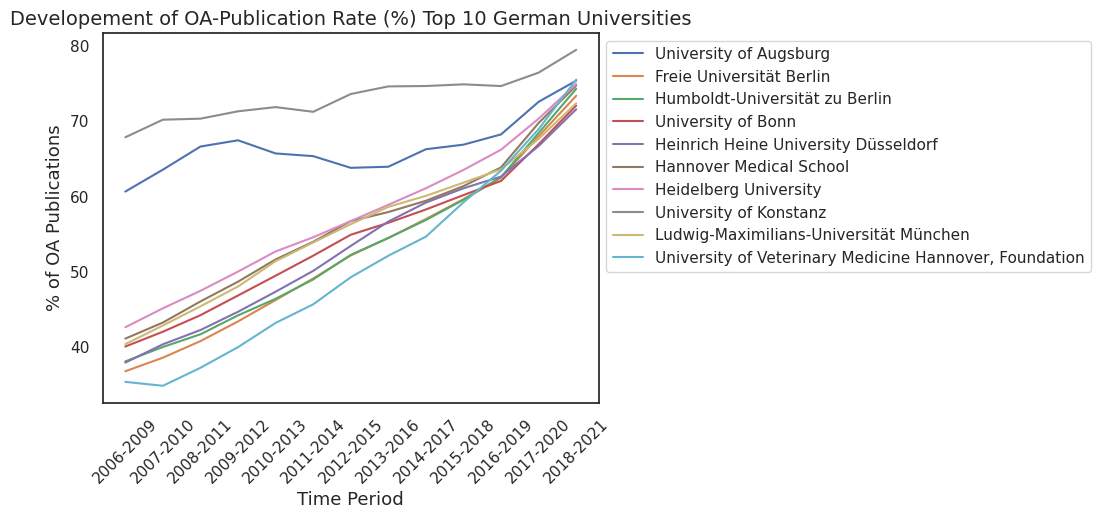

In [22]:
# get historic data from most recent top 10 universities
oa_historic_from_recent_top_10_ger = gdf[['period', 'prop_pubs_oa', 'country',
                                          'university', 'main_field']] \
                                          .loc[gdf.university.isin(german_oa_18_21.university.head(10)) 
                                          & (gdf.main_field == 'All sciences')]

# convert oa rate to %
oa_historic_from_recent_top_10_ger['prop_pubs_oa'] = oa_historic_from_recent_top_10_ger['prop_pubs_oa'] * 100


# create plot
sns.lineplot(data=oa_historic_from_recent_top_10_ger, x='period', y='prop_pubs_oa', hue='university', err_style=None)

# title, labels and other cosmetics
plt.ylabel('% of OA Publications', fontsize=13)
plt.xlabel('Time Period', fontsize=13)
plt.xticks(rotation=45)
plt.title('Developement of OA-Publication Rate (%) Top 10 German Universities', fontsize=14)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

#plt.savefig('plots/oa_publication_rate_dev_top_10_ger_2018-2021.png', bbox_inches='tight')

plt.show()

Next I want to create an interactive map of Europe that shows the open access rates per country (in the period 2018-2021). For this, I downloaded outlines as a geodateframe from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.

In [23]:
# load the shapes of european countries
shapes = gpd.read_file('data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp') # load full data
europe = shapes[shapes['CONTINENT'] == 'Europe'] # subset for europe

In [24]:
# calculate average oa-rate by country for europe for all sciences
# subset the data for all sciences in the period 2018-2021
all_sciences = gdf.loc[(gdf['main_field'] == 'All sciences') & (gdf['period'] == '2018-2021')].reset_index(drop=True)

# calculate the country means
country_means_18_21 = all_sciences.groupby(['country', 'ISO-3'])['prop_pubs_oa'].mean() \
                                  .reset_index().sort_values(by='prop_pubs_oa', ascending=False)

# merge the country means with the europe country shapes
europe_means = europe.merge(country_means_18_21, how='inner', left_on='NAME', right_on='country')

# convert oa rate to %
europe_means['prop_pubs_oa'] = round(europe_means['prop_pubs_oa']*100, 1)

In [25]:
europe_means.head()

featurecla  scalerank  LABELRANK SOVEREIGNT SOV_A3  ADM0_DIF  LEVEL  \
0  Admin-0 country          1          2     Russia    RUS         0      2   
1  Admin-0 country          1          3     Norway    NOR         0      2   
2  Admin-0 country          1          2     France    FR1         1      2   
3  Admin-0 country          1          3     Sweden    SWE         0      2   
4  Admin-0 country          1          3     Poland    POL         0      2   

                TYPE   TLC   ADMIN  ... FCLASS_GR  FCLASS_IT FCLASS_NL  \
0  Sovereign country     1  Russia  ...      None       None      None   
1  Sovereign country  None  Norway  ...      None       None      None   
2            Country     1  France  ...      None       None      None   
3  Sovereign country     1  Sweden  ...      None       None      None   
4  Sovereign country     1  Poland  ...      None       None      None   

  FCLASS_SE  FCLASS_BD FCLASS_UA  \
0      None       None      None   
1      None       None      None   
2      None       None      None   
3      None       None      None   
4      None       None      None   

                                            geometry  country ISO-3  \
0  MULTIPOLYGON (((178.7253 71.0988, 180 71.51571...   Russia   RUS   
1  MULTIPOLYGON (((15.14282 79.67431, 15.52255 80...   Norway   NOR   
2  MULTIPOLYGON (((-51.6578 4.15623, -52.24934 3....   France   FRA   
3  POLYGON ((11.02737 58.85615, 11.46827 59.43239...   Sweden   SWE   
4  POLYGON ((23.48413 53.9125, 23.52754 53.47012,...   Poland   POL   

  prop_pubs_oa  
0         50.8  
1         76.0  
2         75.1  
3         76.9  
4         66.8  

[5 rows x 172 columns]

In [26]:
# load plotly graph objects to create an interactive map object
import plotly.graph_objects as go

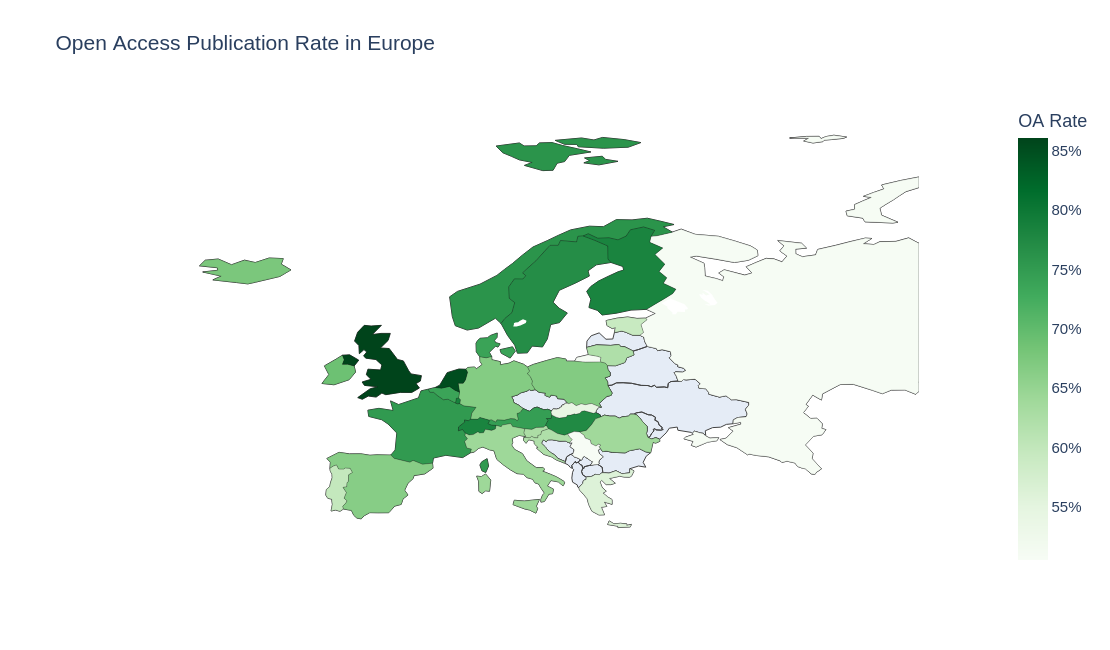

In [27]:
# create choropleth map
fig = go.Figure(data=go.Choropleth(locations=europe_means['ISO-3'], # accesses countries (refers to ISO-3 column)
                                   z=europe_means['prop_pubs_oa'], # basis for colour shade
                                   text=europe_means['country'], # description in hover popup
                                   colorscale='Greens', # add color scale
                                   autocolorscale=False,
                                   reversescale=False,
                                   marker_line_color='black', # make borders black
                                   marker_line_width=0.2,
                                   colorbar_title='OA Rate',
                                   colorbar_ticksuffix='%'))

fig.update_layout(autosize=False, # set custom size of the map
                  width=1000,
                  height=650,
                  title_text='Open Access Publication Rate in Europe', # set title
                  font=dict(size=15), # set font size
                  geo=dict(showcoastlines=False,
                           projection_type='equirectangular',
                           scope='europe'))

#fig.write_html('plots/oa_map_europe_2018-2021.html')
fig.show()        

In [28]:
# load plotly express to create interactive stacked bar charts
import plotly.express as px

In [29]:
# prep data for plotting
# first group by field and get means for each desired column
# then create pivot table for the columns
# but first subset for 2018-2021 and only european countries
gdf_fields = gdf.loc[(gdf['period'] == '2018-2021') & gdf['country'].isin(europe_means['country'].unique())].reset_index(drop=True)
gdf_fields = gdf_fields.groupby('main_field')[['prop_pubs_gold_oa', 
                                  'prop_pubs_hybrid_oa', 
                                  'prop_pubs_bronze_oa', 
                                  'prop_pubs_green_oa']].mean().stack().reset_index().rename(columns={'level_1':'oa_color',
                                                                                                      0:'prop'})
# convert proportions to percent
gdf_fields['prop'] = round(gdf_fields['prop']*100, 1)

# rename values of oa color
gdf_fields.loc[gdf_fields['oa_color'] == 'prop_pubs_gold_oa', 'oa_color'] = 'Gold'
gdf_fields.loc[gdf_fields['oa_color'] == 'prop_pubs_hybrid_oa', 'oa_color'] = 'Hybrid'
gdf_fields.loc[gdf_fields['oa_color'] == 'prop_pubs_bronze_oa', 'oa_color'] = 'Bronze'
gdf_fields.loc[gdf_fields['oa_color'] == 'prop_pubs_green_oa', 'oa_color'] = 'Green'

# convert main field strings to look nicer
gdf_fields['main_field'] = gdf_fields['main_field'].str.title()

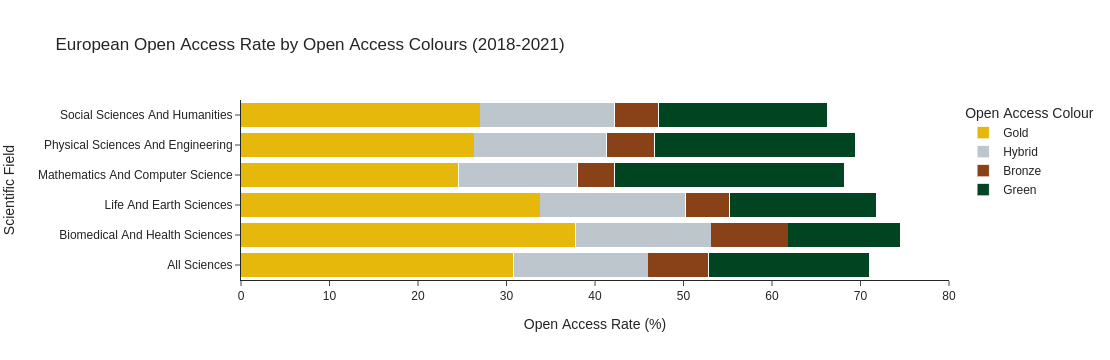

In [31]:
# plotting
fig = px.bar(gdf_fields, x='prop', y='main_field', color='oa_color', # set variables
             barmode='stack', orientation='h', # stacked horizontal bars
             title='European Open Access Rate by Open Access Colours (2018-2021)', # set title
             labels={'main_field':'Scientific Field', # set x, y and color labels
                     'prop':'Open Access Rate (%)',
                     'oa_color':'Open Access Colour'},
             color_discrete_map={'Gold': '#E5B80B', # set custom bar colors
                                 'Hybrid': '#BCC6CC',
                                 'Bronze': '#894218',
                                 'Green': '#014421'},
             template='simple_white') # set the graph theme

# change x-axis range
fig.update_layout(
            xaxis_range=[0, 80])

#fig.write_html('plots/oa_rate_fields_colors_europe_2018-2021.html')
fig.show()


### For Germany only

In [32]:
# prep data for plotting
# first group by field and get means for each desired column
# then create pivot table for the columns
gdf_fields_ger = gdf.loc[(gdf['period'] == '2018-2021') & (gdf['country'] == 'Germany')].reset_index(drop=True)
gdf_fields_ger = gdf_fields_ger.groupby('main_field')[['prop_pubs_gold_oa', 
                                        'prop_pubs_hybrid_oa', 
                                        'prop_pubs_bronze_oa', 
                                        'prop_pubs_green_oa']].mean().stack().reset_index().rename(columns={'level_1':'oa_color',
                                                                                                          0:'prop'})
# convert proportions to percent
gdf_fields_ger['prop'] = round(gdf_fields_ger['prop']*100, 1)

# rename values of oa color
gdf_fields_ger.loc[gdf_fields_ger['oa_color'] == 'prop_pubs_gold_oa', 'oa_color'] = 'Gold'
gdf_fields_ger.loc[gdf_fields_ger['oa_color'] == 'prop_pubs_hybrid_oa', 'oa_color'] = 'Hybrid'
gdf_fields_ger.loc[gdf_fields_ger['oa_color'] == 'prop_pubs_bronze_oa', 'oa_color'] = 'Bronze'
gdf_fields_ger.loc[gdf_fields_ger['oa_color'] == 'prop_pubs_green_oa', 'oa_color'] = 'Green'

# convert main field strings to look nicer
gdf_fields_ger['main_field'] = gdf_fields_ger['main_field'].str.title()

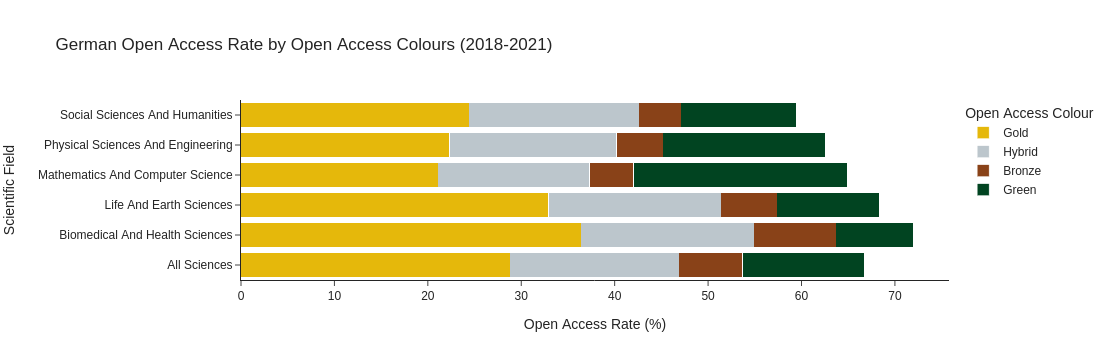

In [33]:
# plotting
fig = px.bar(gdf_fields_ger, x='prop', y='main_field', color='oa_color', # set variables
             barmode='stack', orientation='h', # stacked horizontal bars
             title='German Open Access Rate by Open Access Colours (2018-2021)', # set title
             labels={'main_field':'Scientific Field', # set x, y and color labels
                     'prop':'Open Access Rate (%)',
                     'oa_color':'Open Access Colour'},
             color_discrete_map={'Gold': '#E5B80B', # set custom bar colors
                                 'Hybrid': '#BCC6CC',
                                 'Bronze': '#894218',
                                 'Green': '#014421'},
             template='simple_white') # set the graph theme

fig.show()

In [34]:
gdf_fields.groupby('main_field')['prop'].sum()

main_field
All Sciences                         71.0
Biomedical And Health Sciences       74.5
Life And Earth Sciences              71.8
Mathematics And Computer Science     68.2
Physical Sciences And Engineering    69.4
Social Sciences And Humanities       66.2
Name: prop, dtype: float64

### Preparing Data for Correlation Analysis
I want to see if there are correlations between open access rates and university microdata such as number of students, third party funding, ranking etc. For that I join the dataframe that contains OA information for the "All Sciences" field in the period 2018-2021 with the 2021 Times Higher Education (THE) Ranking Scores and the 2021 Data from the European Teriary Education Register.

Unfortunately, the THE ranking uses university names that were somehow ambiguous which (ironically) led to the wrong ROR being accessed through the ROR API. As a result of this, some universities that may be both in the CWTS Leiden Open Ranking and the THE ranking may not be included in the joined table.

In [35]:
# all ETER universities from the Leiden Open Ranking
ETER_all_sciences = all_sciences.join(eter.set_index('ror_id'), on='ror_id', how='inner').reset_index(drop=True)

# this list is incomplete because of strange naming in the THE ranking
# which leads to some rors being identified incorrectly
THE_all_sciences = the.join(all_sciences.set_index('ror_id'), on='ror_id', how='inner').reset_index(drop=True)

In [36]:
for t in [ETER_all_sciences, THE_all_sciences]:
    print(t.shape)

(454, 24)
(978, 27)


Let's start with assessing correlations in universities included in the Leiden Open Ranking and the THE ranking. This dataset contains 978 universities and a total of 34 columns.

We will exclude text columns that are not relevant for the correlation analysis. Additionally, there are a number of columns that we would expect to have extremely high correlation scores (e.g. number of publications will strongly correlate with number of open access publications). We will remove such autocorrelated columns. Similarly, the top 1 and top 10 papers from the Leiden Open Ranking data are based on citations. The THE Ranking has a cumulative citations score, only this one will be included.

### For ranking data

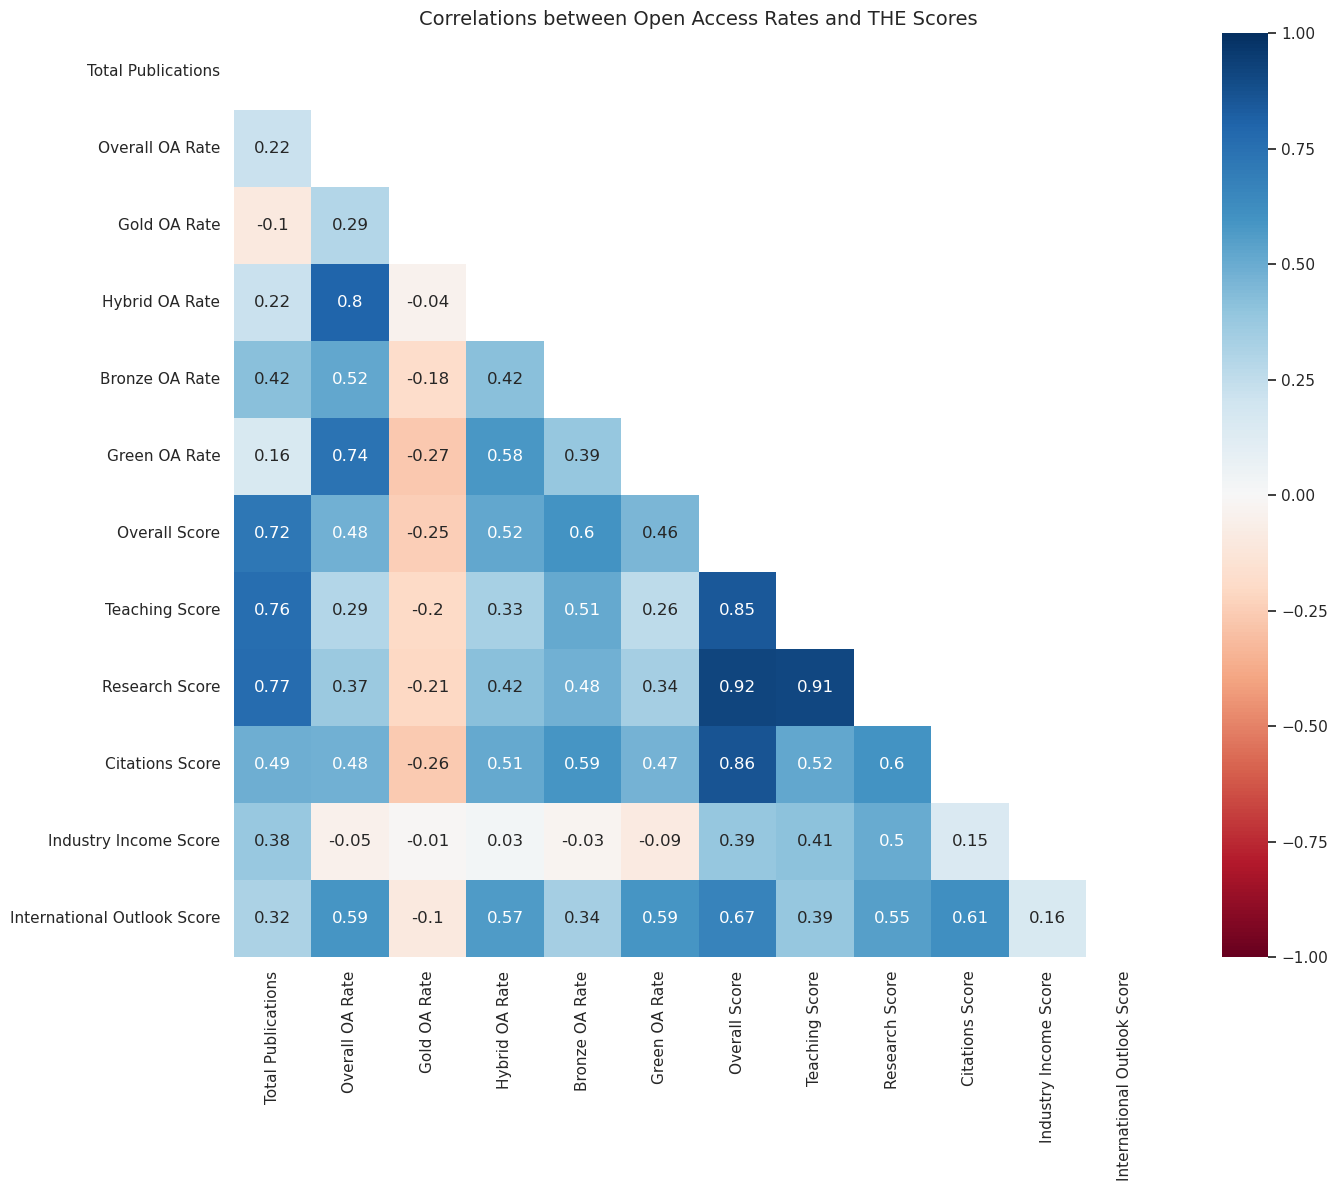

In [37]:
# subset the data
THE_all_sciences_ranking = THE_all_sciences[['num_pubs', 'prop_pubs_oa', 'prop_pubs_gold_oa', 'prop_pubs_hybrid_oa',
                                              'prop_pubs_bronze_oa', 'prop_pubs_green_oa', 'overall score', 'teaching score', 
                                              'research score', 'citations score', 'industry income score', 'intl outlook score']]

# give columns understandable names
THE_all_sciences_ranking = THE_all_sciences_ranking.rename(columns={'num_pubs': 'Total Publications',
                                                                              'prop_pubs_oa': 'Overall OA Rate',
                                                                              'prop_pubs_gold_oa': 'Gold OA Rate', 
                                                                              'prop_pubs_hybrid_oa': 'Hybrid OA Rate', 
                                                                              'prop_pubs_bronze_oa': 'Bronze OA Rate',
                                                                              'prop_pubs_green_oa': 'Green OA Rate',
                                                                              'overall score': 'Overall Score',
                                                                              'teaching score': 'Teaching Score', 
                                                                              'research score': 'Research Score',
                                                                              'citations score': 'Citations Score',
                                                                              'industry income score': 'Industry Income Score',
                                                                              'intl outlook score': 'International Outlook Score'})

# create correlation matrix
ranking_corr_matrix = THE_all_sciences_ranking.corr().round(2)

# create a mask with numpy
mask = np.triu(np.ones_like(ranking_corr_matrix, dtype=bool))

# create plot
plt.figure(figsize=(15,12))
sns.heatmap(ranking_corr_matrix,
            cmap='RdBu', # set color map red to blues
            vmin=-1, vmax=1, # set min and max scores
            annot=True, # add annotations
            mask=mask) # add the mask so we don't have redundancies
plt.title('Correlations between Open Access Rates and THE Scores', fontsize=14) # set title

#plt.savefig('plots/oa_the_corr.png', bbox_inches='tight')
plt.show()

I think the most interesting THE scores for OA correlations are the Overall Score, the Research Score and the Citations Score so I will only use those.

In [38]:
# reshape data for plotting
oa_the_corr = THE_all_sciences_ranking.melt(id_vars=['Overall Score', 'Research Score', 'Citations Score'],
                                            value_vars=['Overall OA Rate', 'Gold OA Rate', 'Hybrid OA Rate',
                                                        'Bronze OA Rate', 'Green OA Rate'],
                                            var_name = 'OA Colour',
                                            value_name = '% of Total Publications').reset_index()

oa_the_corr = oa_the_corr.melt(id_vars=['OA Colour', '% of Total Publications'],
                                            value_vars=['Overall Score', 'Research Score', 'Citations Score'],
                                            var_name = 'Category',
                                            value_name = 'Score')

# convert oa rate to %
oa_the_corr['% of Total Publications'] = oa_the_corr['% of Total Publications'] * 100

# change oa colour values so they only include the colours
oa_the_corr['OA Colour'] = oa_the_corr['OA Colour'].str.replace(' OA Rate', '')

oa_the_corr.head()

OA Colour  % of Total Publications       Category  Score
0   Overall                87.225272  Overall Score   95.6
1   Overall                71.211459  Overall Score   94.9
2   Overall                74.059748  Overall Score   94.8
3   Overall                83.707901  Overall Score   94.5
4   Overall                80.971988  Overall Score   94.4

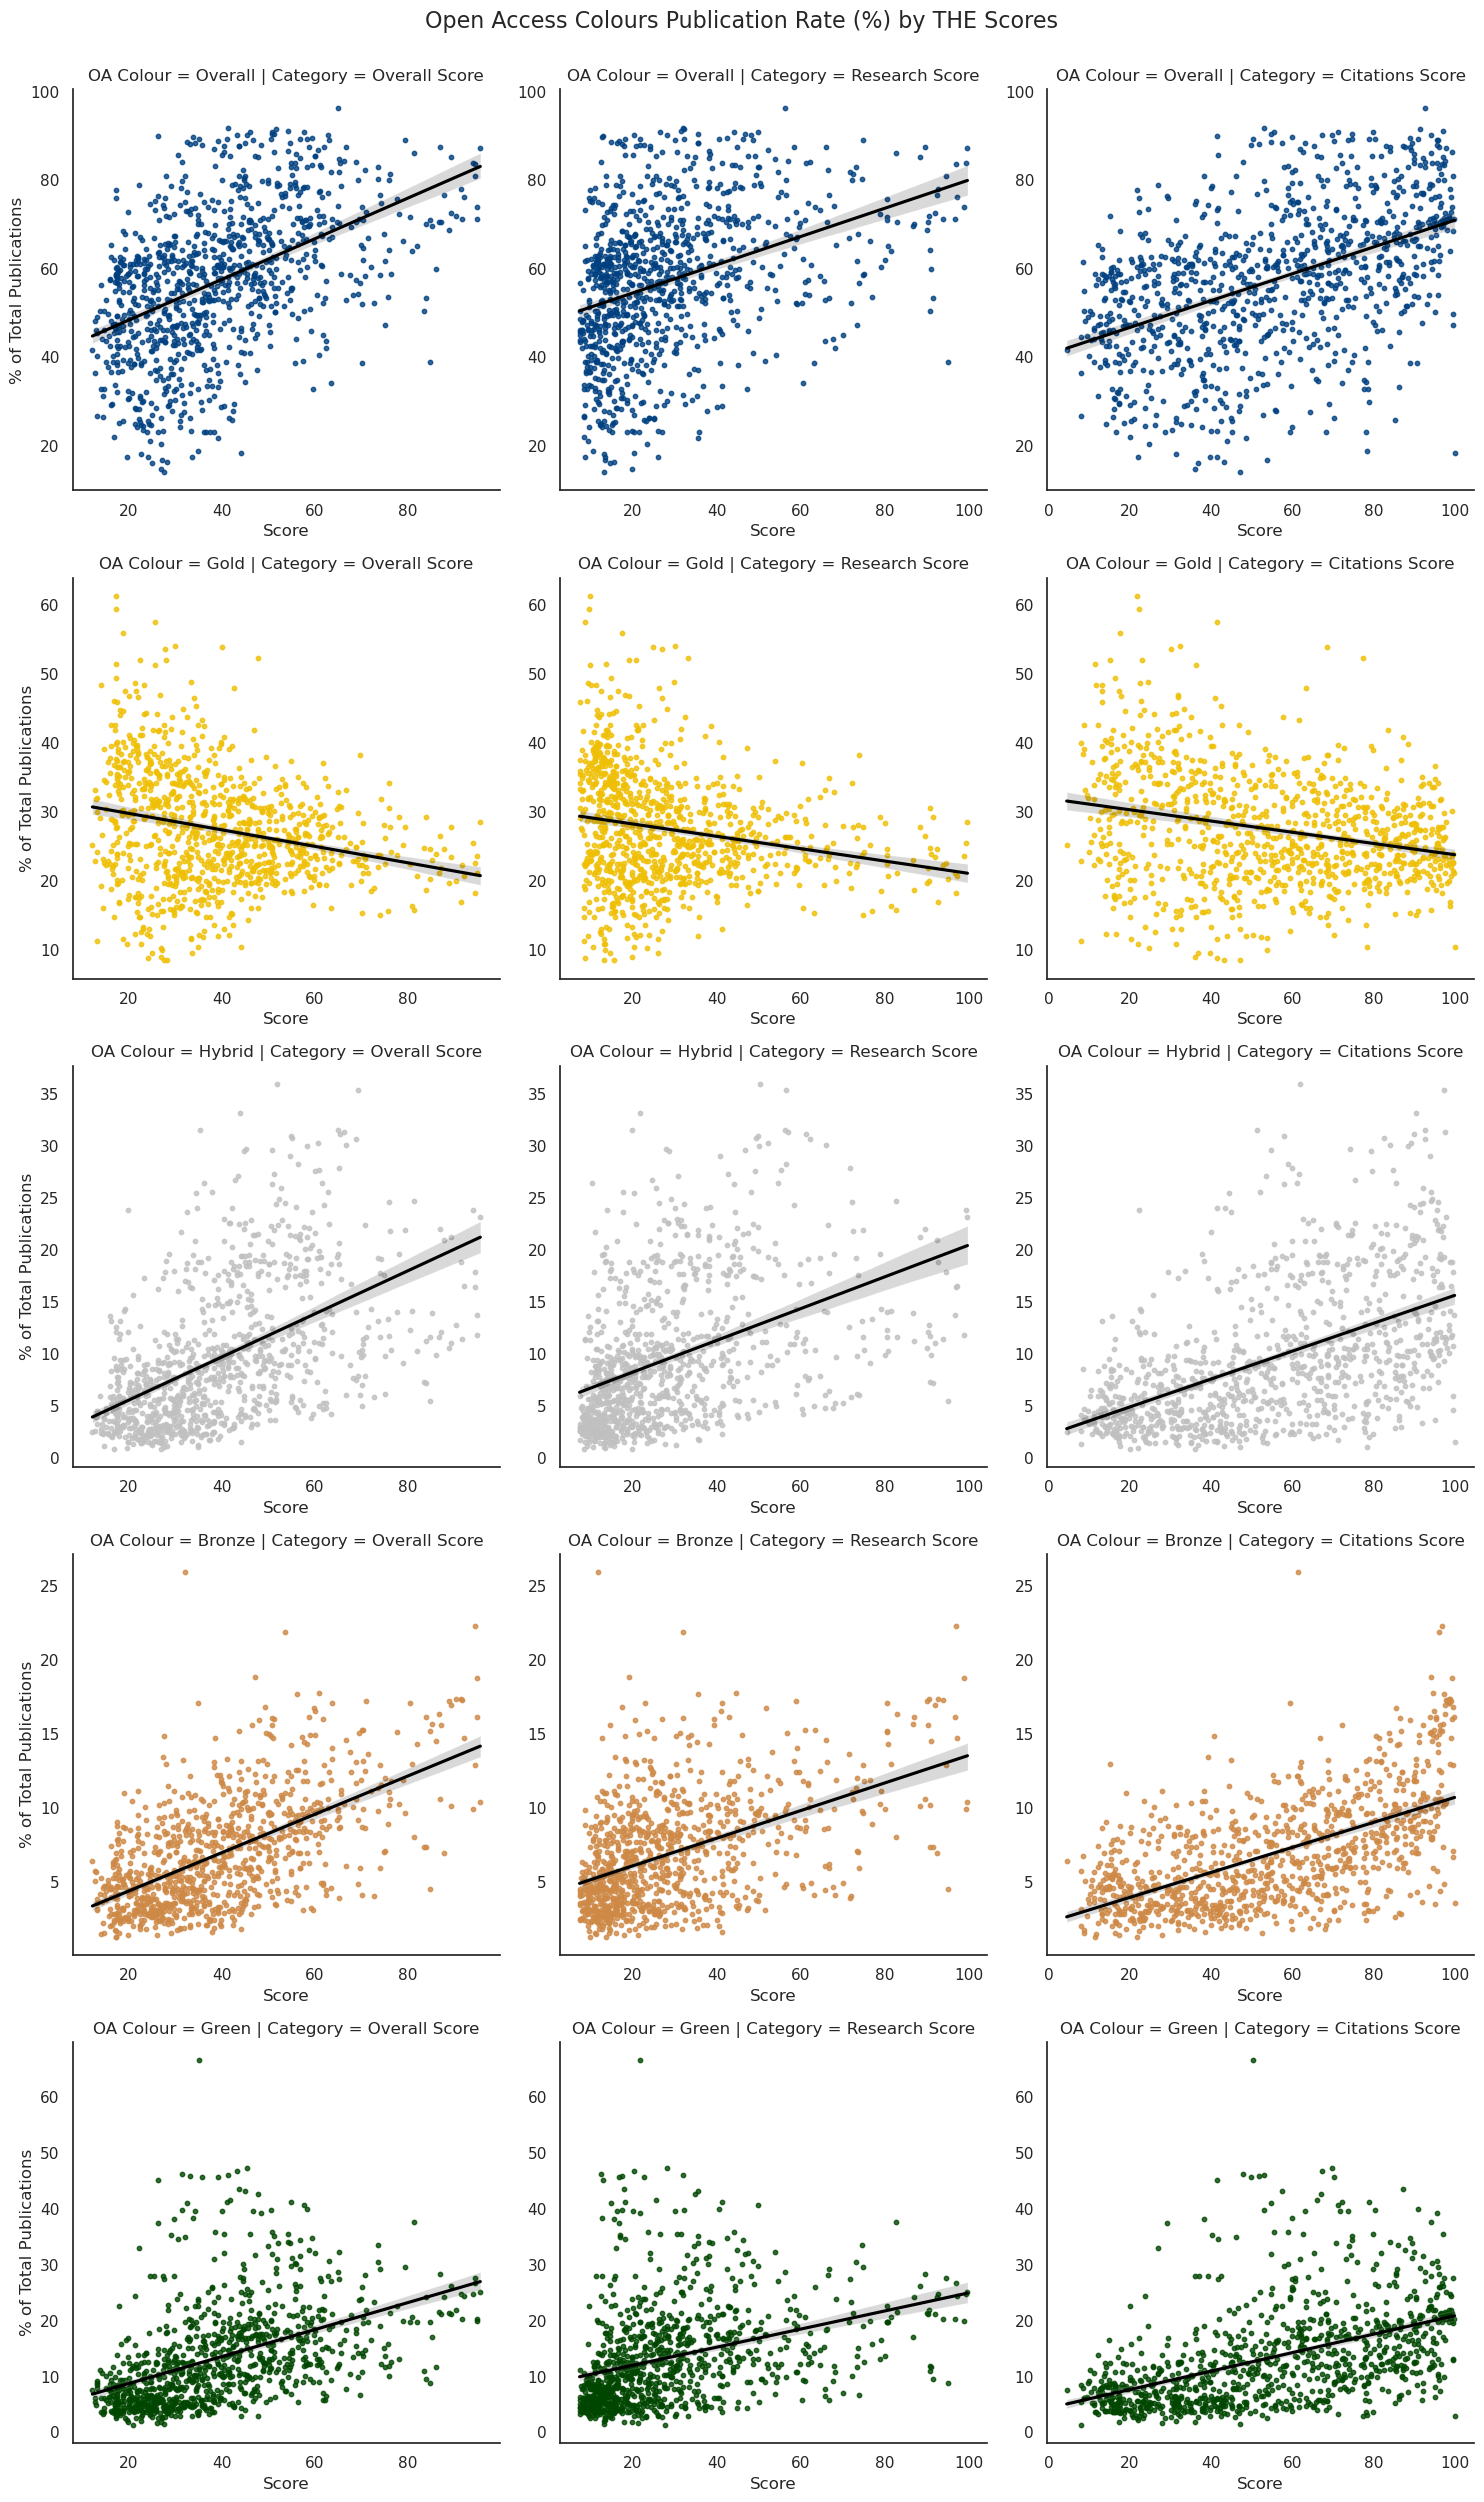

In [39]:
# set a color palette
color_pal_corr = sns.color_palette(['#004080', '#EFBF04', '#C0C0C0', '#CE8946', '#004600'])

g = sns.lmplot(oa_the_corr, x='Score', y='% of Total Publications', # plot variables
               col='Category', row='OA Colour', hue='OA Colour', # facet grid and colours
               sharex=False, sharey=False, # don't share the axes
               palette=color_pal_corr, # add custom colour palette
               line_kws={'color': 'black'}, # make lines black
               scatter_kws={'s': 10}) # change size of scatter points

# add xlabel to every facet
for ax in g.axes.flat:
    ax.set_xlabel('Score')

# add figure title
g.fig.suptitle('Open Access Colours Publication Rate (%) by THE Scores', fontsize=16, y=1)

plt.tight_layout()
#plt.savefig('plots/oa_the_corr.png')
plt.show()

Second, let's assessing correlations in universities included in the Leiden Open Ranking with the ETER microdata. This dataset contains 454 universities and a total of 31 columns. Unfortunately, almost half (208) of the universities don't have ETER information on the Total third party funding. This value cannot be sensibly imputet. Therefore the correlation scores for this variable will be based on only 246 values. Similarly, there are 29 missing values for personnel count and 6 missing values for student count.

Again I exclude text columns that are not relevant for the correlation analysis and autocorrelated columns.

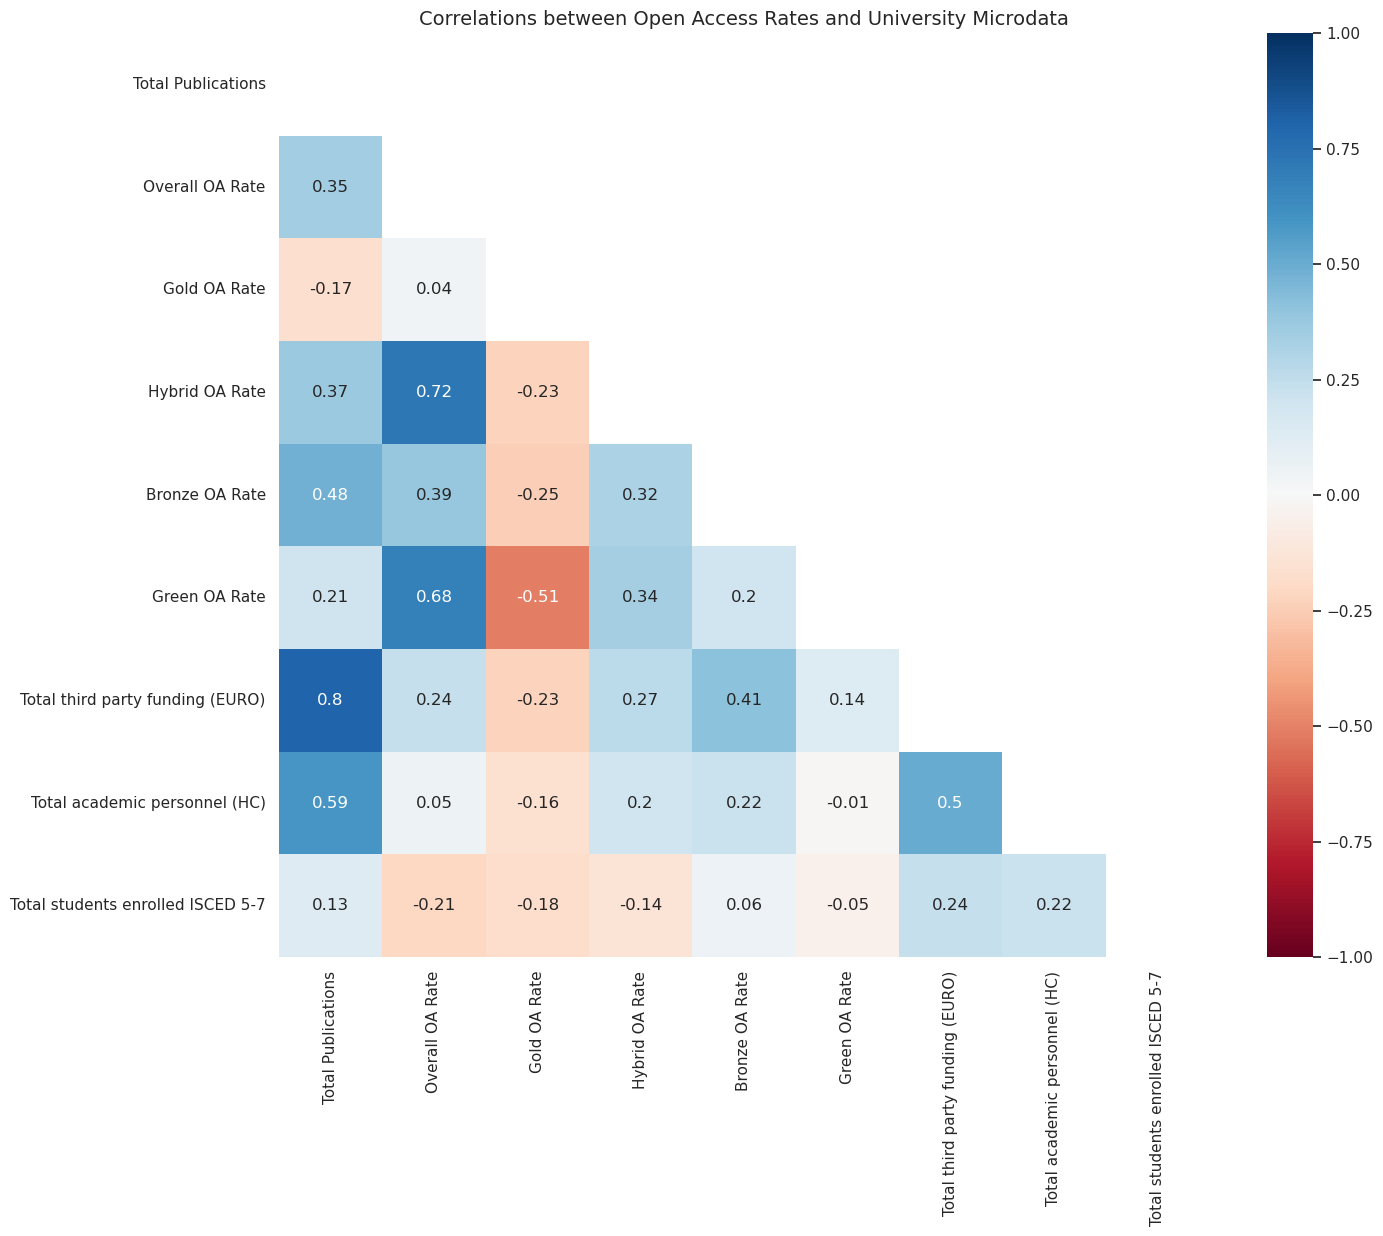

In [40]:
# subset relevant columns
ETER_all_sciences_uni_microdata = ETER_all_sciences[['num_pubs', 'prop_pubs_oa', 'prop_pubs_gold_oa', 
                                                     'prop_pubs_hybrid_oa', 'prop_pubs_bronze_oa', 'prop_pubs_green_oa', 
                                                     'Total third party funding (EURO)', 'Total academic personnel (HC)', 
                                                     'Total students enrolled ISCED 5-7']]

# give columns understandable names
ETER_all_sciences_uni_microdata = ETER_all_sciences_uni_microdata.rename(columns={'num_pubs': 'Total Publications',
                                                                                  'prop_pubs_oa': 'Overall OA Rate',
                                                                                  'prop_pubs_gold_oa': 'Gold OA Rate', 
                                                                                  'prop_pubs_hybrid_oa': 'Hybrid OA Rate', 
                                                                                  'prop_pubs_bronze_oa': 'Bronze OA Rate',
                                                                                  'prop_pubs_green_oa': 'Green OA Rate'})
# create correlation matrix
microdata_corr_matrix = ETER_all_sciences_uni_microdata.corr().round(2)

# create a mask with numpy
mask = np.triu(np.ones_like(microdata_corr_matrix, dtype=bool))

plt.figure(figsize=(15,12))
sns.heatmap(microdata_corr_matrix, 
            cmap='RdBu', # color map red-blue
            vmin=-1, vmax=1, # min max values on the scale
            annot=True, # add annotations
            mask=mask) # add the numpy mask

plt.title('Correlations between Open Access Rates and University Microdata', fontsize=14)
#plt.savefig('plots/oa_eter_corr.png', bbox_inches='tight')
plt.show()

## Correlation Third Party Funding - Open Access Rates
To me the correlation between 'Total Third Party Funding' and the Open Access Publishing Rates is the most interesting so I want to take a closer look at it. There are a few extrem Third Party Funding values in the dataset that could 1. skew the correlations and 2. make the following plots look unclearly.

### Remove Outliers
Remove all values that are more than 2 times the inter quartile range away from the median.

In [41]:
def remove_outliers(df, col_name):
    """
    Removes outliers. Using 2 times IQR distance from median.
    """
    # calculate IQR
    IQR = df[col_name].quantile(0.75) - df[col_name].quantile(0.25)
    
    # calculate upper and lower threshold for exclusion
    upper = df[col_name].median() + (2 * IQR)
    lower = df[col_name].median() - (2 * IQR)

    # return df with excluded values
    return df.loc[(df[col_name] >= lower) & (df[col_name] <= upper)]

#ETER_all_sciences_uni_microdata_x = remove_outliers(ETER_all_sciences_uni_microdata, 'Total third party funding (EURO)')
ETER_all_sciences_uni_microdata_cp = ETER_all_sciences_uni_microdata.copy()

# remove outliers
ETER_all_sciences_uni_microdata_cp = remove_outliers(ETER_all_sciences_uni_microdata_cp, 'Total third party funding (EURO)')

# a lot of the values that were dropped are NULL values
# these would be ignored anyway
print(ETER_all_sciences_uni_microdata.shape, ETER_all_sciences_uni_microdata_cp.shape)

(454, 9) (231, 9)


In [42]:
# reshape dataframe so we have a column for oa color
oa_micro_corr = ETER_all_sciences_uni_microdata_cp.melt(id_vars = ['Total third party funding (EURO)', 'Total Publications', 
                                                'Total academic personnel (HC)', 'Total students enrolled ISCED 5-7'],
                                    value_vars = ['Overall OA Rate', 'Gold OA Rate', 'Hybrid OA Rate', 'Bronze OA Rate', 'Green OA Rate'],
                                    var_name = 'Open Access Colour',
                                    value_name = '% of Total Publications')

# remove the 'OA Rate' from the values for the OA color column
oa_micro_corr['Open Access Colour'] = oa_micro_corr['Open Access Colour'].str.replace(' OA Rate', '')

In [43]:
# transform values to be more intuitive
# convert to %
oa_micro_corr['% of Total Publications'] = oa_micro_corr['% of Total Publications'] * 100

# convert to mio euros
oa_micro_corr['Total third party funding (EURO)'] = oa_micro_corr['Total third party funding (EURO)'] / 1000000

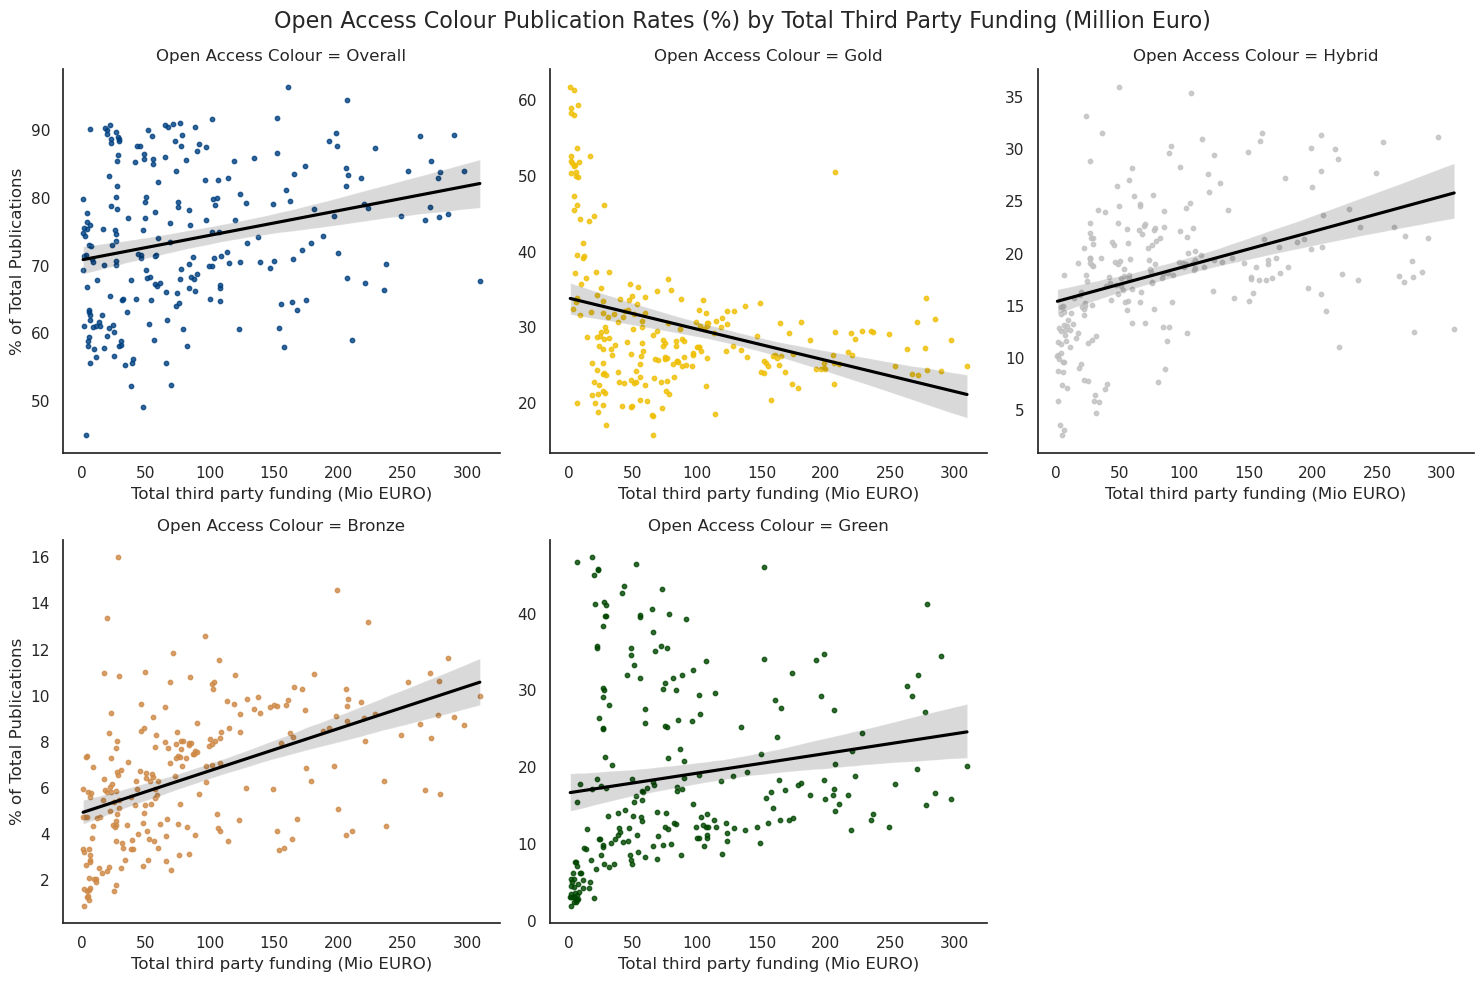

In [44]:
# create lmplot
g = sns.lmplot(oa_micro_corr, x='Total third party funding (EURO)', y='% of Total Publications', # plot variables
               col='Open Access Colour', hue='Open Access Colour', # colour and facets
               palette=color_pal_corr, # add custom color palette
               col_wrap=3, # max 3 facets per row
               sharex=False, sharey=False, # don't share axes
               scatter_kws={'s': 10}, # change scatter point size
               line_kws={'color': 'black'} # change line color to black
               )

# set x label for each facet
for ax in g.axes.flat:
    ax.set_xlabel('Total third party funding (Mio EURO)')


# set figure title
g.fig.suptitle('Open Access Colour Publication Rates (%) by Total Third Party Funding (Million Euro)', fontsize=16)

# avoid overlap
plt.tight_layout()
#plt.savefig('plots/oa_funding_corr.png')
plt.show()